# Perfect Virtual- 
Cryptocurrency usecase: Utilise a form  of Recurrent Neural Network (RNN) model for the prediction of Bitcoin prices from historical data and analysis of social media trends. 
## Build Process:
1. Generate API key to access Bitcoin data from the [cryptocompare API](https://min-api.cryptocompare.com/)
2. Choose relevent data features e.g. price, volume, online engagement
3. Preprocess the data
4. Build the model architecture 
5. Train the model
6. Evaluate model performance
7. Identify feature importance

In [1]:
import numpy as np 
from numpy import concatenate
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import keras 
import json
import seaborn as sns
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from keras import layers
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
#scikitlearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import cryptocompare
import requests
from datetime import datetime
# pretty printing of pandas dataframe
pd.set_option('expand_frame_repr', False) 

In [2]:
apiKey = "98901418980628c0e095f5d511be7435c1cbf090ed813f6c82fc88a8f939c9a3"

In [3]:
from_symbol = 'BTC'
to_symbol = 'USD'
exchange = 'Bitstamp'
datetime_interval = 'day'

In [4]:
def get_filename(from_symbol, to_symbol, exchange, datetime_interval, download_date):
    return '%s_%s_%s_%s_%s.csv' % (from_symbol, to_symbol, exchange, datetime_interval, download_date)


def download_data(from_symbol, to_symbol, exchange, datetime_interval):
    supported_intervals = {'minute', 'hour', 'day'}
    assert datetime_interval in supported_intervals,\
        'datetime_interval should be one of %s' % supported_intervals

    print('Downloading %s trading data for %s %s from %s' %
          (datetime_interval, from_symbol, to_symbol, exchange))
    base_url = 'https://min-api.cryptocompare.com/data/histo'
    url = '%s%s' % (base_url, datetime_interval)

    params = {'fsym': from_symbol, 'tsym': to_symbol,
              'limit': 2000, 'aggregate': 1,
              'e': exchange}
    request = requests.get(url, params=params)
    data = request.json()
    return data


def convert_to_dataframe(data):
    df = pd.io.json.json_normalize(data, ['Data'])
    df['datetime'] = pd.to_datetime(df.time, unit='s')
    df = df[['datetime', 'low', 'high', 'open',
             'close', 'volumefrom', 'volumeto']]
    return df
def filter_empty_datapoints(df):
    indices = df[df.sum(axis=1) == 0].index
    print('Filtering %d empty datapoints' % indices.shape[0])
    df = df.drop(indices)
    return df


data = download_data(from_symbol, to_symbol, exchange, datetime_interval)
df = convert_to_dataframe(data)
df = filter_empty_datapoints(df)

current_datetime = datetime.now().date().isoformat()
filename = get_filename(from_symbol, to_symbol, exchange, datetime_interval, current_datetime)
print('Saving data to %s' % filename)
df.to_csv(filename, index=False)

C:\Users\matth\AppData\Local\Temp/ipykernel_7408/2307276692.py:24: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = pd.io.json.json_normalize(data, ['Data'])
C:\Users\matth\AppData\Local\Temp/ipykernel_7408/2307276692.py:30: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  indices = df[df.sum(axis=1) == 0].index


Filtering 0 empty datapoints
Saving data to BTC_USD_Bitstamp_day_2021-11-12.csv


In [5]:
import pandas as pd

def read_dataset(filename):
    print('Reading data from %s' % filename)
    df = pd.read_csv(filename)
    df.datetime = pd.to_datetime(df.datetime) # change type from object to datetime
    df = df.set_index('datetime') 
    df = df.sort_index() # sort by datetime
    print(df.shape)
    return df

df = read_dataset(filename)

Reading data from BTC_USD_Bitstamp_day_2021-11-12.csv
(2001, 6)


In [6]:
df.tail()

,low,high,open,close,volumefrom,volumeto
datetime,,,,,,
2021-11-08,63300.00,67803.55,63300.00,67559.00,2715.42,1.785721e+08
2021-11-09,66250.00,68564.40,67559.00,66945.72,2136.86,1.442011e+08
2021-11-10,62856.71,69000.00,66945.72,64921.43,3419.12,2.265382e+08
2021-11-11,64140.00,65625.44,64921.43,64821.33,1583.28,1.028043e+08
2021-11-12,63755.01,65497.53,64821.33,64084.81,656.18,4.247396e+07


In [7]:
def plot_data(df, from_symbol, to_symbol):  
    from pandas.plotting import register_matplotlib_converters
    register_matplotlib_converters()
    
    plt.figure(figsize=(15,5))
    plt.title('{} / {} price data'.format(from_symbol, to_symbol))
    plt.plot(df.index, df.close)
    plt.legend()
    plt.show()
    
    return None

No handles with labels found to put in legend.


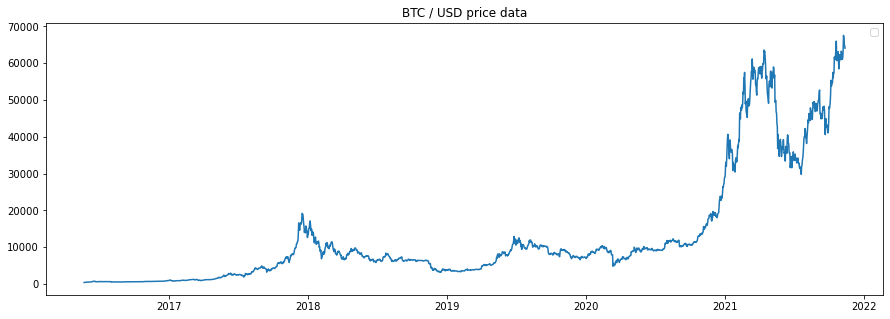

In [8]:
plot_data(df, from_symbol, to_symbol)

In [9]:
#change to consider close, low, high,, volumefrome and volumeto
from sklearn.preprocessing import MinMaxScaler
values = df['close'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [10]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

1400 601


In [11]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [12]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

1399
600


In [13]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [14]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
#Initialize the RNN
model = Sequential() 
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2)) 
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2)) 
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.5)) 
#model.add(LSTM(units = 120, activation = 'relu'))
#model.add(Dropout(0.5)) 
model.add(Dense(units =1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 1, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 60)             26640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 60)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 80)             45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 80)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 1)              8

In [15]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

Epoch 1/50
109/112 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 0.0000e+00
Epoch 00001: val_loss improved from inf to 0.00539, saving model to my_best_model.hdf5
112/112 [==============================] - 2s 18ms/step - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 0.0054 - val_accuracy: 0.0000e+00
Epoch 2/50
111/112 [============================>.] - ETA: 0s - loss: 0.0025 - accuracy: 0.0000e+00
Epoch 00002: val_loss improved from 0.00539 to 0.00173, saving model to my_best_model.hdf5
112/112 [==============================] - 1s 7ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 3/50
102/112 [==========================>...] - ETA: 0s - loss: 5.0924e-04 - accuracy: 0.0000e+00
Epoch 00003: val_loss improved from 0.00173 to 0.00011, saving model to my_best_model.hdf5
112/112 [==============================] - 1s 8ms/step - loss: 4.9776e-04 - accuracy: 0.0000e+00 - val_loss: 1.1409e-04 - val_accuracy: 0.0000e+00
E

112/112 [==============================] - ETA: 0s - loss: 2.4419e-04 - accuracy: 0.0000e+00
Epoch 00027: val_loss did not improve from 0.00004
112/112 [==============================] - 1s 7ms/step - loss: 2.4419e-04 - accuracy: 0.0000e+00 - val_loss: 5.4394e-05 - val_accuracy: 0.0000e+00
Epoch 28/50
107/112 [===========================>..] - ETA: 0s - loss: 2.7099e-04 - accuracy: 0.0000e+00
Epoch 00028: val_loss did not improve from 0.00004
112/112 [==============================] - 1s 6ms/step - loss: 2.7170e-04 - accuracy: 0.0000e+00 - val_loss: 4.2450e-05 - val_accuracy: 0.0000e+00
Epoch 29/50
108/112 [===========================>..] - ETA: 0s - loss: 2.9875e-04 - accuracy: 0.0000e+00
Epoch 00029: val_loss did not improve from 0.00004
112/112 [==============================] - 1s 6ms/step - loss: 2.9428e-04 - accuracy: 0.0000e+00 - val_loss: 4.1651e-05 - val_accuracy: 0.0000e+00
Epoch 30/50
108/112 [===========================>..] - ETA: 0s - loss: 2.4079e-04 - accuracy: 0.0000e+0

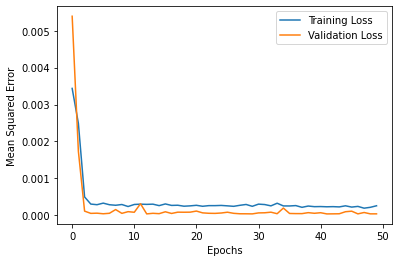

In [16]:
#create callback
filepath = 'my_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

#fit the model
history = model.fit(X_train,
                  y_train,
                  batch_size=10,
                  epochs=50,
                  validation_split=0.2,
                  callbacks=callbacks)

#plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.savefig('model_training_history')
plt.show()

In [17]:
model = load_model(filepath)

In [18]:
Y_pred = model.predict(X_test) 

In [19]:
pred_inverse = scaler.inverse_transform(Y_pred.reshape(-1, 1))
Ytest_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

In [20]:
rmse = sqrt(mean_squared_error(Ytest_inverse, pred_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5022.094


In [21]:
predictDates = df.tail(len(X_test)).index

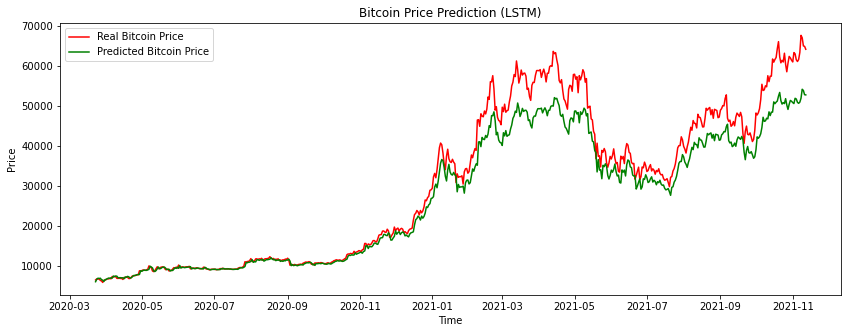

In [22]:
plt.figure(figsize=(14,5))
plt.plot(predictDates,Ytest_inverse, color = 'red', label = 'Real Bitcoin Price')
plt.plot(predictDates,pred_inverse, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction (LSTM)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()